In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from msresist.clinical_data import *
from msresist.pre_processing import filter_NaNpeptides, preprocessing
from msresist.clustering import DDMC
import statannot

matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1.5, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

### Import CPTAC Data

In [2]:
phos = filter_NaNpeptides(pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:], tmt=2)
prot = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_Protein.csv").drop_duplicates(subset="geneSymbol").set_index("geneSymbol").select_dtypes(include=float).iloc[:, 4:].reset_index()
rna = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_RNAseq.csv").drop_duplicates(subset="geneSymbol")

_, phosR_tumor, _ = preprocess_phospho(phos)
protR, protR_tumor, _ = preprocess_data(prot)
_, rnaR_tumor, _ = preprocess_data(rna)

pmut = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
pmut = pmut[~pmut["Sample.ID"].str.contains("IR")]
id_to_stage = dict(zip(list(pmut["Sample.ID"]), list(pmut["Stage"])))
id_to_egfr = dict(zip(list(pmut["Sample.ID"]), list(pmut["EGFR.mutation.status"])))

/Users/creixell/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Import AXL signaling Data

In [3]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)

In [4]:
X.insert(0, "Cluster", ddmc.labels())
c123 = X[(X["Cluster"] == 1) | (X["Cluster"] == 2) | (X["Cluster"] == 3)][["Cluster", "Gene", "Position", "PC9 A", "KO A"]]
c123.head()

In [5]:
protHL = make_AXL_categorical_data(protR_tumor, protR_tumor, phospho=False, by_samples=True, by_thres=False)

In [6]:
protHL = make_AXL_categorical_data(protR_tumor, protR_tumor, phospho=False, by_samples=True, by_thres=False)
rm = ['SEPT2', 'FYB1', 'CAVIN1', 'KIRREL1', 'CFL1', 'CBLC', 'ICK', 'NME2', 'PSMA2', 'HSPA8', 'GPRC5B', 'ITCH', 'ABL1', 'RBM14', 'PIK3R3', 'SOS1', 'MTOR', 'HGS', 'EPHA5', 'SGMS2', 'SRSF1']
genes = [*set(list(c123["Gene"]))]
for _ in range(5):
    for p in genes:
        if p in rm:
            genes.remove(p)

phl = protHL.reset_index().set_index("geneSymbol").loc[genes]

In [7]:
df_p = phl.reset_index()
p_long = pd.melt(df_p, "geneSymbol", df_p.columns[1:], "Sample", "Log(protein expression)")
p_long.insert(1, "AXL", [s.split("_")[0] for s in p_long["Sample"]])
p_long.insert(2, "Patient ID", [s.split("_")[1] for s in p_long["Sample"]])
p_long.insert(3, "EGFR mutational status", [id_to_egfr[s] for s in p_long["Patient ID"]])
p_long["EGFR mutational status"] = p_long["EGFR mutational status"].replace(0, "EGFR WT")
p_long["EGFR mutational status"] = p_long["EGFR mutational status"].replace(1, "EGFRm")

In [8]:
c1 = [c for c in X[X["Cluster"] == 1]["Gene"].to_list() if c in genes]
c2 = [c for c in X[X["Cluster"] == 2]["Gene"].to_list() if c in genes]
c3 = [c for c in X[X["Cluster"] == 3]["Gene"].to_list() if c in genes]
c4 = [c for c in X[X["Cluster"] == 4]["Gene"].to_list() if c in genes]
c5 = [c for c in X[X["Cluster"] == 5]["Gene"].to_list() if c in genes]

In [9]:
c1 = p_long.set_index("geneSymbol").loc[c1].reset_index()
c1.insert(1, "Cluster", "1")
c2 = p_long.set_index("geneSymbol").loc[c2].reset_index()
c2.insert(1, "Cluster", "2")
c3 = p_long.set_index("geneSymbol").loc[c3].reset_index()
c3.insert(1, "Cluster", "3")
c4 = p_long.set_index("geneSymbol").loc[c4].reset_index()
c4.insert(1, "Cluster", "4")
c5 = p_long.set_index("geneSymbol").loc[c5].reset_index()
c5.insert(1, "Cluster", "5")

cs_long = pd.concat([c1, c2, c3, c4, c5])
cs_long['zscore'] = ((cs_long['Log(protein expression)'] - cs_long["Log(protein expression)"].mean()) / cs_long["Log(protein expression)"].std())

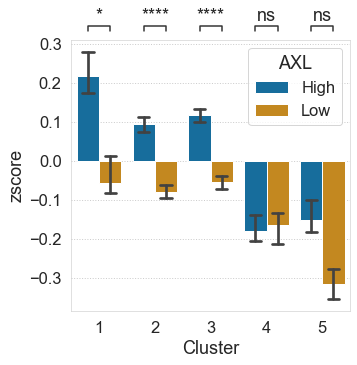

In [10]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(data=cs_long, x="Cluster", y="zscore", hue="AXL", ax=ax, ci=68, capsize=0.2, estimator=np.median)
statannot.add_stat_annotation(
        ax=ax, 
        data=cs_long, 
        x="Cluster", 
        hue="AXL",
        y="zscore",
        box_pairs=[
        (("1", "Low"), ("1", "High")),
        (("2", "Low"), ("2", "High")),
        (("3", "Low"), ("3", "High")),
        (("4", "Low"), ("4", "High")),
        (("5", "Low"), ("5", "High")),
        ],
        test="Mann-Whitney", 
        text_format="star", 
        loc="outside",
        verbose=False);
# plt.savefig("Cs_prot_exp.svg")

In [11]:
phosR_tumor = phosR_tumor.reset_index()
phos_long = pd.melt(phosR_tumor, ["Gene", "Position"], phosR_tumor.columns[3:], "Patient ID", "norm p-signal")

phos_long.insert(3, "EGFR mutational status", [id_to_egfr[s] for s in phos_long["Patient ID"]])
phos_long.insert(4, "Stage", [id_to_stage[s] for s in phos_long["Patient ID"]])

axl_by_samples = list(make_AXL_categorical_data(protR_tumor, protR_tumor, phospho=False, by_samples=True, by_thres=False).columns)
id_to_axl = {}
for c in axl_by_samples:
    s = c.split("_")
    id_to_axl[s[1]] = s[0]
phos_long.insert(5, "AXL levels", [id_to_axl[s] if s in id_to_axl.keys() else "High" for s in phos_long["Patient ID"]])

psites = list(zip(list(X["Gene"]), list(X["Position"])))
all_ps = list(zip(list(phos_long["Gene"]), list(phos_long["Position"])))
ovp = [ps for ps in psites if ps in all_ps]
phos_long_ovp = phos_long.set_index(["Gene", "Position"]).loc[ovp].reset_index()

In [12]:
Xc1 = X[X["Cluster"] == 1]
Xc2 = X[X["Cluster"] == 2]
Xc3 = X[X["Cluster"] == 3]
Xc4 = X[X["Cluster"] == 4]
Xc5 = X[X["Cluster"] == 5]

Xc1 = list(zip(list(Xc1["Gene"]), list(Xc1["Position"])))
Xc2 = list(zip(list(Xc2["Gene"]), list(Xc2["Position"])))
Xc3 = list(zip(list(Xc3["Gene"]), list(Xc3["Position"])))
Xc4 = list(zip(list(Xc4["Gene"]), list(Xc4["Position"])))
Xc5 = list(zip(list(Xc5["Gene"]), list(Xc5["Position"])))

phos_gp = list(zip(list(phos_long_ovp["Gene"]), list(phos_long_ovp["Position"])))

In [13]:
cl_agm = []
for g, p in phos_gp:
    if (g, p) in Xc1:
        cl_agm.append(1)
    elif (g, p) in Xc2:
        cl_agm.append(2)
    elif (g, p) in Xc3:
        cl_agm.append(3)
    elif (g, p) in Xc4:
        cl_agm.append(4)
    elif (g, p) in Xc5:
        cl_agm.append(5)
assert len(cl_agm) == len(phos_gp)

phos_long_ovp.insert(1, "Cluster", cl_agm)

In [14]:
phos_long_ovp["EGFR mutational status"] = phos_long_ovp["EGFR mutational status"].replace(0, "EGFR WT")
phos_long_ovp["EGFR mutational status"] = phos_long_ovp["EGFR mutational status"].replace(1, "EGFRm")

In [15]:
cdk1 = phos_long_ovp[(phos_long_ovp["Gene"] == "CDK1") & (phos_long_ovp["Position"] == "Y15-p;T14-p")]
cdk1["norm p-signal"] *= -1
phos_long_ovp = pd.concat([phos_long_ovp.reset_index(), cdk1])
phos_long_ovp["EGFR mutational status"] = phos_long_ovp["EGFR mutational status"].replace(0, "EGFR WT")
phos_long_ovp["EGFR mutational status"] = phos_long_ovp["EGFR mutational status"].replace(1, "EGFRm")
phos_long_ovp['zscore'] = ((phos_long_ovp['norm p-signal'] - phos_long_ovp["norm p-signal"].mean()) / phos_long_ovp["norm p-signal"].std())

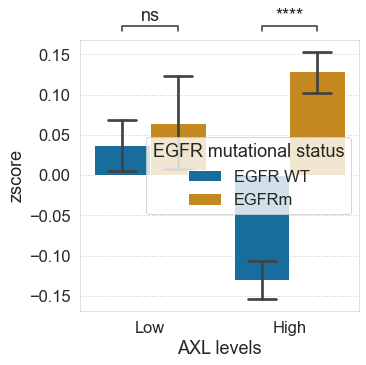

In [16]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.barplot(data=phos_long_ovp, x="AXL levels", y="zscore", hue="EGFR mutational status", capsize=0.2, ax=ax, ci=68)
statannot.add_stat_annotation(
        ax=ax, 
        data=phos_long_ovp,
        x="AXL levels", 
        y="norm p-signal",  
        box_pairs=[
                (("Low", "EGFR WT"), ("Low", "EGFRm")),
                (("High", "EGFR WT"), ("High", "EGFRm")),
        ],
        hue= "EGFR mutational status",
        test="Mann-Whitney", 
        text_format="star", 
        loc="outside",
        verbose=False);

# plt.savefig("phos_AXLhilow.svg")

In [17]:
cs_long["Log(protein expression)"] = cs_long["Log(protein expression)"].astype(float)

In [18]:
phos_c1 = phos_long[phos_long["Gene"].isin(set(c1["geneSymbol"]))]
phos_c2 = phos_long[phos_long["Gene"].isin(set(c2["geneSymbol"]))]
phos_c3 = phos_long[phos_long["Gene"].isin(set(c3["geneSymbol"]))]
phos_c4 = phos_long[phos_long["Gene"].isin(set(c4["geneSymbol"]))]
phos_c5 = phos_long[phos_long["Gene"].isin(set(c5["geneSymbol"]))]

phos_c1.insert(0, "Cluster", 1)
phos_c2.insert(0, "Cluster", 2)
phos_c3.insert(0, "Cluster", 3)
phos_c4.insert(0, "Cluster", 4)
phos_c5.insert(0, "Cluster", 5)
        
phos_cs = pd.concat([phos_c1, phos_c2, phos_c3, phos_c4, phos_c5])
phos_cs['zscore'] = ((phos_cs['norm p-signal'] - phos_cs["norm p-signal"].mean()) / phos_cs["norm p-signal"].std())
phos_cs["EGFR mutational status"] = phos_cs["EGFR mutational status"].replace(0, "EGFR WT")
phos_cs["EGFR mutational status"] = phos_cs["EGFR mutational status"].replace(1, "EGFRm")

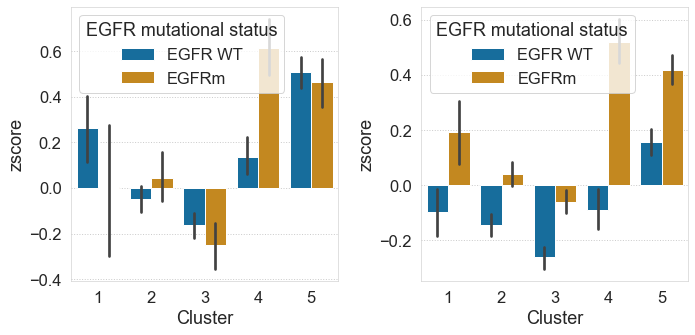

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=phos_long_ovp[phos_long_ovp["AXL levels"] == "Low"], x="Cluster", y="zscore", hue="EGFR mutational status", ci=68, ax=ax[0])
sns.barplot(data=phos_long_ovp[phos_long_ovp["AXL levels"] == "High"], x="Cluster", y="zscore", hue="EGFR mutational status", ci=68, ax=ax[1])
plt.tight_layout()

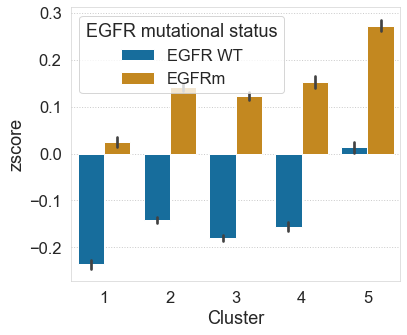

In [20]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
# sns.barplot(data=phos_cs[phos_cs["AXL levels"] == "Low"], x="Cluster", y="zscore", hue="EGFR mutational status", ci=68, ax=ax[0])
sns.barplot(data=phos_cs[phos_cs["AXL levels"] == "High"], x="Cluster", y="zscore", hue="EGFR mutational status", ci=68, ax=ax)
plt.tight_layout()
# plt.savefig("AXL_highlow_cs.svg")

<AxesSubplot:xlabel='Stage', ylabel='zscore'>

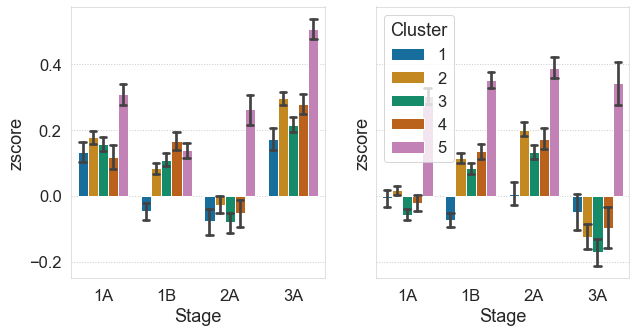

In [21]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axl_high = phos_cs[(phos_cs["EGFR mutational status"] == "EGFRm") & (phos_cs["AXL levels"] == "High")]
sns.barplot(data=axl_high, x="Stage", y="zscore", hue="Cluster", ax=ax[0], ci=68, order=["1A", "1B", "2A", "3A"], capsize=0.1)
ax[0].get_legend().remove()

axl_low = phos_cs[(phos_cs["EGFR mutational status"] == "EGFR WT") & (phos_cs["AXL levels"] == "Low")]
sns.barplot(data=axl_low, x="Stage", y="zscore", hue="Cluster", ax=ax[1], ci=68, order=["1A", "1B", "2A", "3A"], capsize=0.1)
# plt.savefig("EGFmVSwt_stages.svg")

In [32]:
pvals = pd.read_csv("AXLclusters_pvals_TCGA.csv")
pvals["logrank p-value"] = -np.log10(pvals["logrank p-value"])
pvals = pvals.rename(columns={"logrank p-value": "-log10(p-value)"})
pvals.head()

,Cluster,Cancer Type,Metric,-log10(p-value),n_high,n_low,Group Cutoff
0,1,LUAD,DSF,0.309804,120.00,120,Quartile
1,2,LUAD,DSF,0.481486,120.00,120,Quartile
2,3,LUAD,DSF,0.744727,120.00,120,Quartile
3,4,LUAD,DSF,0.795880,120.00,120,Quartile
4,5,LUAD,DSF,0.431798,0.37,120,Quartile


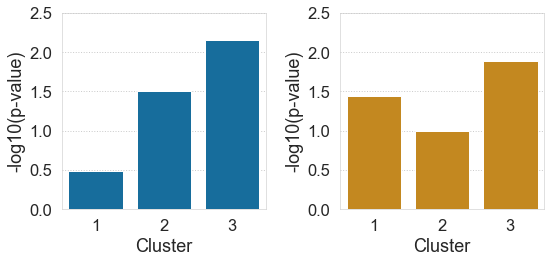

In [66]:
luad_pvals = pvals[(pvals["Cancer Type"] == "LUAD") & (pvals["Metric"] == "OS")].set_index("Cluster").drop([4, 5], axis=0).reset_index()
paad_pvals = pvals[(pvals["Cancer Type"] == "PAAD") & (pvals["Metric"] == "OS")].set_index("Cluster").drop([4, 5], axis=0).reset_index()

_, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.barplot(data=luad_pvals, x="Cluster", y="-log10(p-value)", ax=ax[0], color="#0173b2")
sns.barplot(data=paad_pvals, x="Cluster", y="-log10(p-value)", ax=ax[1], color="#de8f05")
ax[0].set_ylim(0, 2.5)
ax[1].set_ylim(0, 2.5)
plt.tight_layout()

In [63]:
np.log10(0.01)

-2.0

In [ ]:
z